In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/numbers/mnist.csv


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Chargement des données
def load_data(path):
    data = pd.read_csv(path)
    data = np.array(data)
    n, m = data.shape
    np.random.shuffle(data)
    split = int(0.2 * len(data))
    # Séparation données de test et d'entraînement
    data_test = data[0:split].T
    X_test = data_test[1:n]
    y_test = data_test[0]
    X_test = X_test / 255.0
    
    data_train = data[split:n].T
    X_train = data_train[1:n]
    y_train = data_train[0]
    X_train = X_train / 255.0
    
    return X_train, y_train, X_test, y_test

# Fonctions d'activation et leurs dérivées
def relu(Z):
    return np.maximum(0, Z)

def derive_relu(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Pour éviter l'overflow
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

# Encodage one-hot des étiquettes
def one_hot_encode(Y, nb_classes=10):
    Y_encoded = np.zeros((nb_classes, Y.size))
    Y_encoded[Y.astype(int), np.arange(Y.size)] = 1
    return Y_encoded

# Initialisation des paramètres
def initialisation(input_size=784, hidden_size=100, output_size=10):
    np.random.seed(42)  # Pour reproductibilité
    
    # Initialisation de Xavier pour éviter la saturation des gradients
    W1 = np.random.randn(hidden_size, input_size) * np.sqrt(1. / input_size)
    b1 = np.zeros((hidden_size, 1))
    
    W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size)
    b2 = np.zeros((hidden_size, 1))
    
    W3 = np.random.randn(output_size, hidden_size) * np.sqrt(1. / hidden_size)
    b3 = np.zeros((output_size, 1))
    
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

# Propagation avant
def forward_propagation(X, params):
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    W3, b3 = params['W3'], params['b3']
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    
    cache = {
        'Z1': Z1, 'A1': A1,
        'Z2': Z2, 'A2': A2,
        'Z3': Z3, 'A3': A3
    }
    
    return A3, cache

# Rétropropagation
def backward_propagation(X, Y, cache, params):
    m = X.shape[1]
    Y_encoded = one_hot_encode(Y)
    
    A3 = cache['A3']
    A2 = cache['A2']
    A1 = cache['A1']
    
    W3 = params['W3']
    W2 = params['W2']
    
    # Couche de sortie
    dZ3 = A3 - Y_encoded
    dW3 = (1 / m) * np.dot(dZ3, A2.T)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    
    # Deuxième couche cachée
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * derive_relu(cache['Z2'])
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    # Première couche cachée
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * derive_relu(cache['Z1'])
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {
        'dW1': dW1, 'db1': db1,
        'dW2': dW2, 'db2': db2,
        'dW3': dW3, 'db3': db3
    }
    
    return gradients

# Calcul du coût (entropie croisée)
def compute_cost(A3, Y):
    m = Y.shape[0]
    Y_encoded = one_hot_encode(Y)
    cost = -np.sum(Y_encoded * np.log(A3 + 1e-8)) / m
    return cost

# Prédiction
def predict(X, params):
    A3, _ = forward_propagation(X, params)
    return np.argmax(A3, axis=0)

# Calcul de la précision
def compute_accuracy(predictions, Y):
    return np.mean(predictions == Y)

# Mini-batch generator
def mini_batch_generator(X, Y, batch_size=128):
    m = X.shape[1]
    mini_batches = []
    
    # Shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[permutation]
    
    # Partition
    num_complete_minibatches = m // batch_size
    
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * batch_size:(k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[k * batch_size:(k + 1) * batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    # Gestion du dernier mini-batch (si nécessaire)
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    return mini_batches

# Fonction pour afficher les graphiques interactifs à chaque 10 itérations
def plot_training_progress(costs, accuracies, i, iterations, method_name):
    clear_output(wait=True)
    
    plt.figure(figsize=(15, 5))
    
    # Plot du coût
    plt.subplot(1, 2, 1)
    iterations_list = range(0, i+1, 10)
    if len(iterations_list) < len(costs):
        iterations_list = list(iterations_list) + [i]
    plt.plot(iterations_list, costs)
    plt.title(f'{method_name} - Évolution du coût')
    plt.xlabel('Itérations')
    plt.ylabel('Coût')
    plt.grid(True)
    
    # Plot de la précision
    plt.subplot(1, 2, 2)
    plt.plot(iterations_list, accuracies)
    plt.title(f'{method_name} - Évolution de la précision')
    plt.xlabel('Itérations')
    plt.ylabel('Précision')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Itération {i}/{iterations}, Coût: {costs[-1]:.4f}, Précision: {accuracies[-1]:.4f}")

# 1. Descente de Gradient Simple (Mini-Batch)
def gradient_descent(X_train, Y_train, X_test, Y_test, params, alpha=0.1, iterations=500, batch_size=128, plot_every=10, epsilon=1e-18):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A3, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Mise à jour des paramètres
            for param in params:
                params[param] = params[param] - alpha * gradients['d' + param]
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Gradient Descent au point {params}.")
            break
        
        # Calcul du coût et de la précision
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"Gradient descent iteration {i+1} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded


# 2. Gradient avec Momentum
def momentum_gradient_descent(X_train, Y_train, X_test, Y_test, params, alpha=0.1, beta1=0.9, iterations=500, batch_size=128, plot_every=10, epsilon=1e-18):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    velocities = {k: np.zeros_like(v) for k, v in params.items()}
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A3, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Mise à jour des vitesses et des paramètres
            for param in params:
                velocities[param] = beta1 * velocities[param] + (1 - beta1) * gradients['d' + param]
                params[param] = params[param] - alpha * velocities[param]
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Momentum au point {params}.")
            break
        
        # Évaluation sur les données de test
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"Momentum iteration {i+1} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded

#Nestrove Momentum
def nesterov_momentum_gradient_descent(X_train, Y_train, X_test, Y_test, params, alpha=0.1, beta1=0.9, iterations=500, batch_size=128, plot_every=10, epsilon=1e-18):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    velocities = {k: np.zeros_like(v) for k, v in params.items()}
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        
        for X_mini, Y_mini in mini_batches:
            # Anticipation des paramètres
            params_ahead = {k: v - beta1 * velocities[k] for k, v in params.items()}
            
            # Forward propagation avec les paramètres anticipés
            _, cache = forward_propagation(X_mini, params_ahead)
            
            # Backward propagation avec les paramètres anticipés
            gradients = backward_propagation(X_mini, Y_mini, cache, params_ahead)
            
            # Mise à jour des vitesses et des paramètres
            for param in params:
                velocities[param] = beta1 * velocities[param] + (1 - beta1) * gradients['d' + param]
                params[param] = params[param] - alpha * velocities[param]
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Nesterov au point {params}.")
            break
        
        # Évaluation sur les données de test
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"Nesterov iteration {i+1} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded
    
# 4. RMSProp
def rmsprop(X_train, Y_train, X_test, Y_test, params, alpha=0.1, beta2=0.999, epsilon=1e-18, iterations=500, batch_size=128, plot_every=10):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    # Initialisation des accumulateurs de gradients au carré
    squared_gradients = {k: np.zeros_like(v) for k, v in params.items()}
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A3, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Mise à jour des accumulateurs et des paramètres
            for param in params:
                squared_gradients[param] = beta2 * squared_gradients[param] + (1 - beta2) * np.power(gradients['d' + param], 2)
                params[param] = params[param] - alpha * gradients['d' + param] / (np.sqrt(squared_gradients[param]) + 1e-8)
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec RMSProp au point {params}.")
            break
            
        # Calcul du coût et de la précision
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"RMSProp iteration {i+1} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded

# 5. Adam
def adam(X_train, Y_train, X_test, Y_test, params, alpha=0.1, beta1=0.9, beta2=0.999, epsilon=1e-18, iterations=500, batch_size=128, plot_every=10):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    # Initialisation des moments et des accumulateurs de gradients au carré
    velocities = {k: np.zeros_like(v) for k, v in params.items()}
    squared_gradients = {k: np.zeros_like(v) for k, v in params.items()}
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        t = i + 1  # Compteur d'itérations (commence à 1)
        
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A3, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Mise à jour des moments, des accumulateurs et des paramètres
            for param in params:
                velocities[param] = beta1 * velocities[param] + (1 - beta1) * gradients['d' + param]
                squared_gradients[param] = beta2 * squared_gradients[param] + (1 - beta2) * np.power(gradients['d' + param], 2)
                
                velocity_corrected = velocities[param] / (1 - np.power(beta1, t))
                squared_grad_corrected = squared_gradients[param] / (1 - np.power(beta2, t))
                
                params[param] = params[param] - alpha * velocity_corrected / (np.sqrt(squared_grad_corrected) + 1e-8)
        
        # Critère d'arrêt basé sur la norme du gradient
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Adam au point {params}.")
            break
            
        # Calcul du coût et de la précision
        if i % plot_every == 0 or i == iterations - 1:
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            print(f"Adam iteration {i+1} : cost fonction: {cost}, accuracy: {accuracy}")

#methode newton:
def newton_method(X_train, Y_train, X_test, Y_test, params, alpha=0.1, iterations=500, batch_size=128, plot_every=10, epsilon=1e-18):
    costs = []
    accuracies = []
    iterations_recorded = []
    
    # Regularization constant for Hessian inverse approximation - using a slightly smaller value
    eta = 1e-6
    
    for i in range(iterations):
        mini_batches = mini_batch_generator(X_train, Y_train, batch_size)
        
        for X_mini, Y_mini in mini_batches:
            # Forward propagation
            A2, cache = forward_propagation(X_mini, params)
            
            # Backward propagation
            gradients = backward_propagation(X_mini, Y_mini, cache, params)
            
            # Improved Hessian approximation
            for param in params:
                # Using a more robust Hessian approximation with adaptive regularization
                grad_squared = gradients['d' + param] ** 2
                # Avoid division by zero and improve numerical stability
                pseudo_hessian_inv = 1.0 / (np.sqrt(grad_squared) + eta)
                
                # Apply Newton update with dampening factor
                params[param] = params[param] - alpha * pseudo_hessian_inv * gradients['d' + param]
        
        # Stopping criterion based on gradient norm
        grad_norm = np.linalg.norm([np.linalg.norm(gradients['d' + param]) for param in params])
        if grad_norm < epsilon:
            print(f"Convergence atteinte en {i+1} itérations avec Newton au point {params}.")
            break
            
        # Calculate cost and accuracy
        if i % plot_every == 0 or i == iterations - 1:
            # Fixed the syntax error in the original code
            A3, _ = forward_propagation(X_test, params)
            cost = compute_cost(A3, Y_test)
            costs.append(cost)
            
            predictions = predict(X_test, params)
            accuracy = compute_accuracy(predictions, Y_test)
            accuracies.append(accuracy)
            iterations_recorded.append(i)
            
            # Interactive display
            print(f"Newton iteration {i+1} : cost fonction: {cost}, accuracy: {accuracy}")
    
    return params, costs, accuracies, iterations_recorded

# Fonction pour tester le modèle
def test_model(X_test, Y_test, params):
    predictions = predict(X_test, params)
    accuracy = compute_accuracy(predictions, Y_test)
    print(f"Précision sur l'ensemble de test: {accuracy:.4f}")
    return accuracy

# Fonction pour visualiser un chiffre et sa prédiction
def visualize_prediction(X_test, Y_test, params, index):
    prediction = predict(X_test[:, index:index+1], params)[0]
    label = Y_test[index]
    
    print(f"Prédiction: {prediction}")
    print(f"Étiquette réelle: {label}")
    
    # Affichage de l'image
    image = X_test[:, index].reshape(28, 28) * 255
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.title(f"Prédiction: {prediction}, Réelle: {label}")
    plt.axis('off')
    plt.show()

# Fonction pour comparer les résultats de toutes les méthodes à la fin
def plot_final_comparison(results):
    plt.figure(figsize=(15, 10))
    
    # Plot des coûts
    plt.subplot(2, 1, 1)
    for name, result in results.items():
        plt.plot(result['iterations'], result['costs'], label=name)
    
    plt.title('Comparaison de l\'évolution du coût')
    plt.xlabel('Itérations')
    plt.ylabel('Coût')
    plt.legend()
    plt.grid(True)
    
    # Plot des précisions
    plt.subplot(2, 1, 2)
    for name, result in results.items():
        plt.plot(result['iterations'], result['accuracies'], label=name)
    
    plt.title('Comparaison de l\'évolution de la précision')
    plt.xlabel('Itérations')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Comparaison des précisions de test
    test_accuracies = {name: result['test_accuracy'] for name, result in results.items()}
    
    plt.figure(figsize=(12, 6))
    plt.bar(test_accuracies.keys(), test_accuracies.values())
    plt.title('Comparaison des précisions sur l\'ensemble de test')
    plt.xlabel('Méthode')
    plt.ylabel('Précision')
    plt.ylim(0.8, 1.0)  # Ajustez selon vos résultats
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [17]:
# Cellules d'exécution pour un notebook Jupyter
# Cellule 1: Charger les données
# Remplacez par le chemin de votre fichier MNIST
mnist_path = "/kaggle/input/numbers/mnist.csv"
print("Chargement des données...")
X_train, Y_train, X_test, Y_test = load_data(mnist_path)
print(f"Données chargées: {X_train.shape[1]} exemples d'entraînement, {X_test.shape[1]} exemples de test")

#declaration des parametres:
alpha=0.1
beta1=0.9 
iterations=500 
batch_size=128 
plot_every=100
beta2=0.999

Chargement des données...
Données chargées: 33600 exemples d'entraînement, 8400 exemples de test


In [4]:
# Cellule 2: Exécuter la descente de gradient simple
print("Entraînement avec Descente de Gradient Simple...")
params_gd = initialisation()
params_gd, costs_gd, accuracies_gd, iterations_gd = gradient_descent(
    X_train, Y_train, X_test, Y_test, params_gd, alpha=alpha, iterations=iterations, batch_size=batch_size, plot_every=plot_every
)
test_accuracy_gd = test_model(X_test, Y_test, params_gd)



Entraînement avec Descente de Gradient Simple...
Gradient descent iteration 1 : cost fonction: 0.34606694551794703, accuracy: 0.8977380952380952
Gradient descent iteration 101 : cost fonction: 0.13954299008006552, accuracy: 0.9727380952380953
Gradient descent iteration 201 : cost fonction: 0.15350752677195567, accuracy: 0.9723809523809523
Gradient descent iteration 301 : cost fonction: 0.16092310511620753, accuracy: 0.9722619047619048
Gradient descent iteration 401 : cost fonction: 0.16594115198817957, accuracy: 0.9723809523809523
Gradient descent iteration 500 : cost fonction: 0.16985381476553066, accuracy: 0.9725
Précision sur l'ensemble de test: 0.9725


In [5]:
# Cellule 3: Exécuter l'optimisation avec Momentum
print("Entraînement avec Momentum...")
params_momentum = initialisation()
params_momentum, costs_momentum, accuracies_momentum, iterations_momentum = momentum_gradient_descent(
    X_train, Y_train,X_test, Y_test, params_momentum, alpha=alpha, beta1=beta1, iterations=iterations, batch_size=batch_size, plot_every=plot_every
)
test_accuracy_momentum = test_model(X_test, Y_test, params_momentum)



Entraînement avec Momentum...
Momentum iteration 1 : cost fonction: 0.3466457780303578, accuracy: 0.8996428571428572
Momentum iteration 101 : cost fonction: 0.14653193967309247, accuracy: 0.9717857142857143
Momentum iteration 201 : cost fonction: 0.16204934894313106, accuracy: 0.9713095238095238
Momentum iteration 301 : cost fonction: 0.1700773285894632, accuracy: 0.9713095238095238
Momentum iteration 401 : cost fonction: 0.1753009720047112, accuracy: 0.9720238095238095
Momentum iteration 500 : cost fonction: 0.17940008329582655, accuracy: 0.9717857142857143
Précision sur l'ensemble de test: 0.9718


In [6]:
# Cellule 4: Exécuter l'optimisation avec Nesterov Momentum
print("Entraînement avec Nesterov Momentum...")
params_nesterov = initialisation()
params_nesterov, costs_nesterov, accuracies_nesterov, iterations_nesterov = nesterov_momentum_gradient_descent(
    X_train, Y_train, X_test, Y_test, params_nesterov, alpha=alpha, beta1=beta1, iterations=iterations, batch_size=batch_size, plot_every=plot_every
)
test_accuracy_nesterov = test_model(X_test, Y_test, params_nesterov)



Entraînement avec Nesterov Momentum...
Nesterov iteration 1 : cost fonction: 0.3259720222452343, accuracy: 0.9072619047619047
Nesterov iteration 101 : cost fonction: 0.1393309787768026, accuracy: 0.9726190476190476
Nesterov iteration 201 : cost fonction: 0.15346758660552548, accuracy: 0.9725
Nesterov iteration 301 : cost fonction: 0.1609426374961414, accuracy: 0.9721428571428572
Nesterov iteration 401 : cost fonction: 0.16595874509180894, accuracy: 0.9723809523809523
Nesterov iteration 500 : cost fonction: 0.16983899901847838, accuracy: 0.9725
Précision sur l'ensemble de test: 0.9725


In [7]:
# Cellule 5: Exécuter l'optimisation avec RMSProp
print("Entraînement avec RMSProp...")
params_rmsprop = initialisation()
params_rmsprop, costs_rmsprop, accuracies_rmsprop, iterations_rmsprop = rmsprop(
    X_train, Y_train, X_test, Y_test, params_rmsprop, alpha=alpha, beta2=beta2, iterations=iterations, batch_size=batch_size, plot_every=plot_every
)
test_accuracy_rmsprop = test_model(X_test, Y_test, params_rmsprop)


Entraînement avec RMSProp...
RMSProp iteration 1 : cost fonction: 3.540422142019571, accuracy: 0.12642857142857142
RMSProp iteration 101 : cost fonction: 2.3045021355532898, accuracy: 0.10095238095238095
RMSProp iteration 201 : cost fonction: 2.3126569600357167, accuracy: 0.09654761904761905
RMSProp iteration 301 : cost fonction: 2.314247065967766, accuracy: 0.10071428571428571
RMSProp iteration 401 : cost fonction: 2.306364662122061, accuracy: 0.10071428571428571
RMSProp iteration 500 : cost fonction: 2.310075638751527, accuracy: 0.09452380952380952
Précision sur l'ensemble de test: 0.0945


In [8]:
# Cellule 6: Exécuter l'optimisation avec Adam
print("Entraînement avec Adam...")
params_adam = initialisation()
params_adam, costs_adam, accuracies_adam, iterations_adam = adam(
    X_train, Y_train, X_test, Y_test, params_adam, alpha=alpha, beta1=beta1, beta2=beta2, iterations=iterations, batch_size=batch_size, plot_every=plot_every
)
test_accuracy_adam = test_model(X_test, Y_test, params_adam)



Entraînement avec Adam...
Adam iteration 1 : cost fonction: 1.760487856122842, accuracy: 0.30273809523809525
Adam iteration 101 : cost fonction: 0.9356373718000761, accuracy: 0.7095238095238096
Adam iteration 201 : cost fonction: 0.8959260891031045, accuracy: 0.7338095238095238
Adam iteration 301 : cost fonction: 1.0755064336709652, accuracy: 0.6578571428571428
Adam iteration 401 : cost fonction: 0.9485974330941722, accuracy: 0.7246428571428571
Adam iteration 500 : cost fonction: 1.049823551955355, accuracy: 0.666547619047619
Précision sur l'ensemble de test: 0.6665


In [26]:
# Cellule 7: Exécuter l'optimisation avec la méthode de Newton approximée
print("Entraînement avec la méthode de Newton approximée...")
params_newton = initialisation()
params_newton, costs_newton, accuracies_newton, iterations_newton = newton_method(
    X_train, Y_train, X_test, Y_test, params_newton, alpha=alpha, iterations=iterations, batch_size=batch_size, plot_every=plot_every
)
test_accuracy_newton = test_model(X_test, Y_test, params_newton)


Entraînement avec la méthode de Newton approximée...
Newton iteration 1 : cost fonction: 8.342824778366941, accuracy: 0.5330952380952381
Newton iteration 101 : cost fonction: 1.9337076974603487, accuracy: 0.26202380952380955
Newton iteration 201 : cost fonction: 1.8876128907413237, accuracy: 0.2786904761904762
Newton iteration 301 : cost fonction: 1.8883737480055338, accuracy: 0.26726190476190476
Newton iteration 401 : cost fonction: 1.8532529624183471, accuracy: 0.30357142857142855
Newton iteration 500 : cost fonction: 1.8221870172961565, accuracy: 0.2904761904761905
Précision sur l'ensemble de test: 0.2905


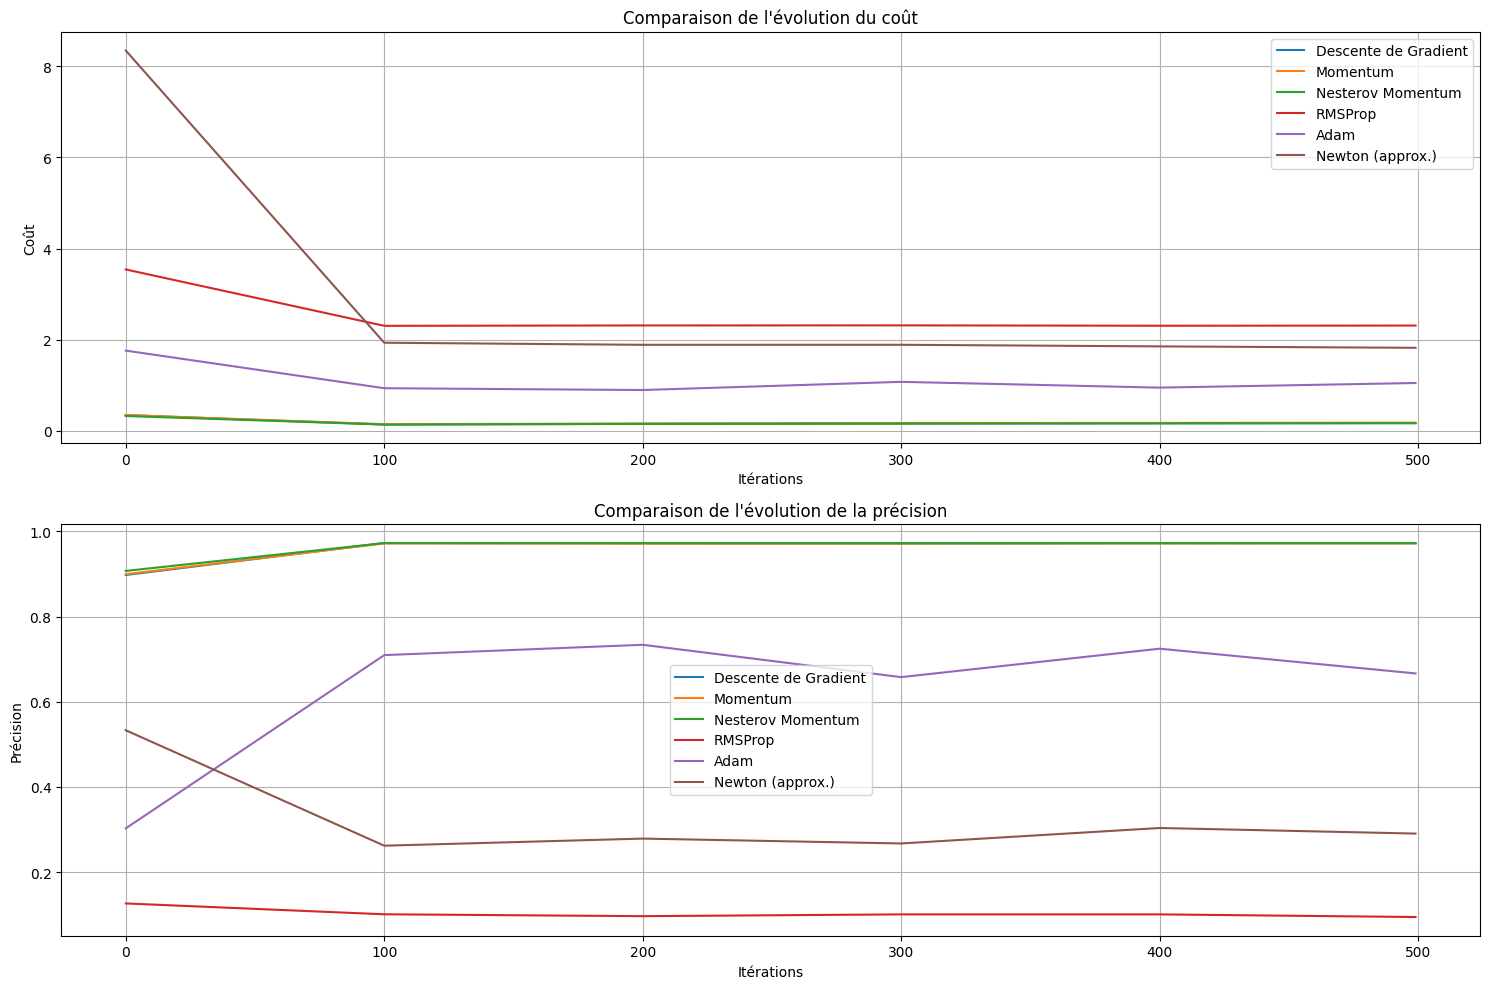

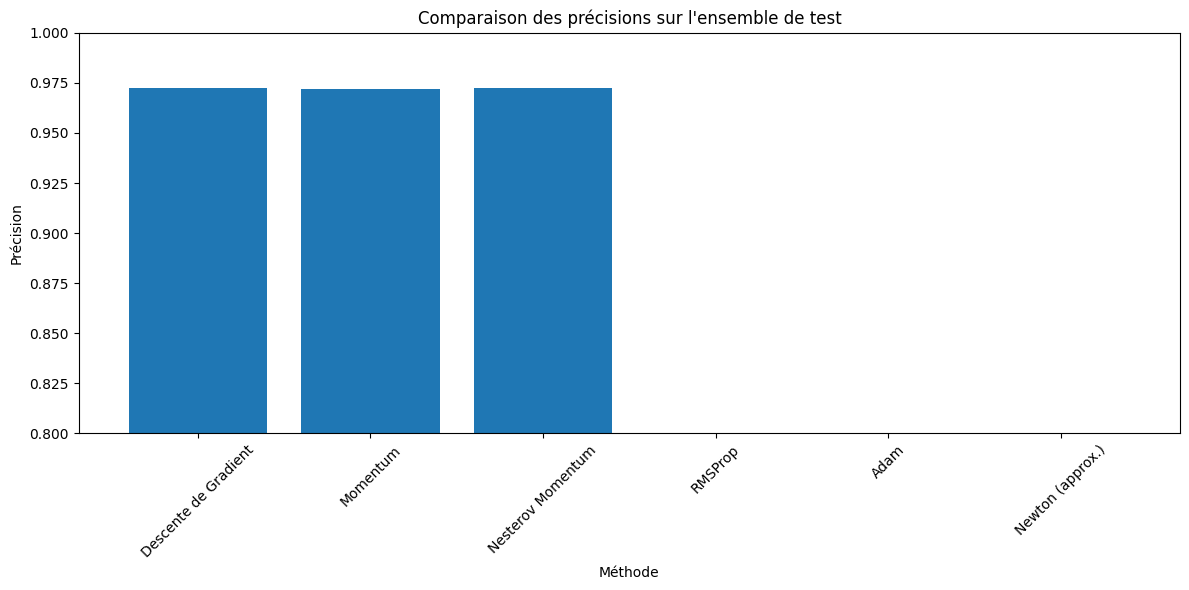

In [27]:


# Cellule 8: Comparer toutes les méthodes
results = {
    "Descente de Gradient": {
        "params": params_gd,
        "costs": costs_gd,
        "accuracies": accuracies_gd,
        "iterations": iterations_gd,
        "test_accuracy": test_accuracy_gd
    },
    "Momentum": {
        "params": params_momentum,
        "costs": costs_momentum,
        "accuracies": accuracies_momentum,
        "iterations": iterations_momentum,
        "test_accuracy": test_accuracy_momentum
    },
    "Nesterov Momentum": {
        "params": params_nesterov,
        "costs": costs_nesterov,
        "accuracies": accuracies_nesterov,
        "iterations": iterations_nesterov,
        "test_accuracy": test_accuracy_nesterov
    },
    "RMSProp": {
        "params": params_rmsprop,
        "costs": costs_rmsprop,
        "accuracies": accuracies_rmsprop,
        "iterations": iterations_rmsprop,
        "test_accuracy": test_accuracy_rmsprop
    },
    "Adam": {
        "params": params_adam,
        "costs": costs_adam,
        "accuracies": accuracies_adam,
        "iterations": iterations_adam,
        "test_accuracy": test_accuracy_adam
    },
    "Newton (approx.)": {
        "params": params_newton,
        "costs": costs_newton,
        "accuracies": accuracies_newton,
        "iterations": iterations_newton,
        "test_accuracy": test_accuracy_newton
    }
}

plot_final_comparison(results)




Meilleure méthode: Descente de Gradient
Prédiction: 0
Étiquette réelle: 0


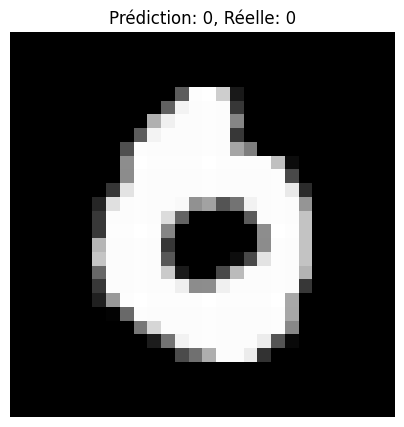

Prédiction: 3
Étiquette réelle: 9


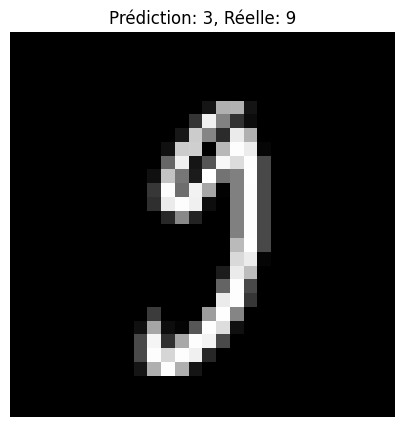

Prédiction: 1
Étiquette réelle: 1


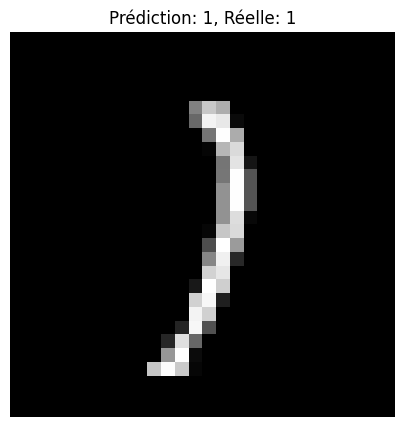

Prédiction: 8
Étiquette réelle: 8


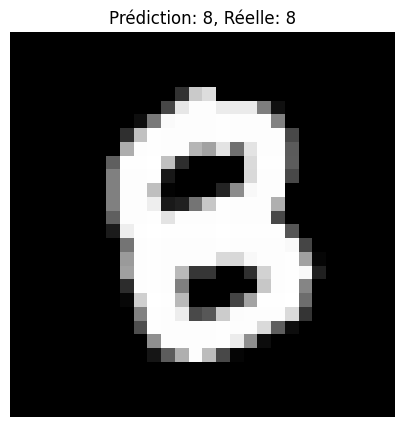

Prédiction: 7
Étiquette réelle: 7


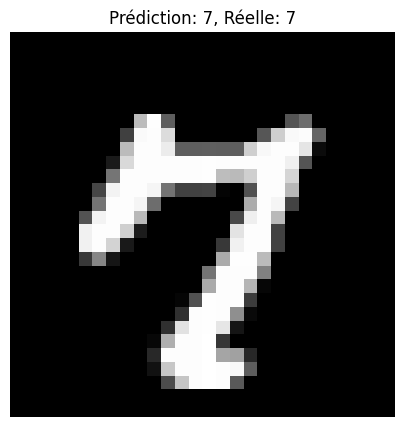

In [28]:
# Cellule 9: Visualiser quelques prédictions avec la meilleure méthode
best_method = max(results.items(), key=lambda x: x[1]['test_accuracy'])[0]
print(f"\nMeilleure méthode: {best_method}")

for i in range(5):
    idx = np.random.randint(0, X_test.shape[1])
    visualize_prediction(X_test, Y_test, results[best_method]['params'], idx)